# 1. Libraries

### A. Install required Packages

In [59]:
# !pip install matplotlib
# !pip install seaborn
# !pip install cmdstanpy
# !pip install arviz
# !pip install geopandas
# !pip install mapclassify

### B. Import Packages

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

import geopandas as gpd

from loadData import load_data

# 2. Datasets

### A. Import the datasets

In [61]:
## Get file paths
csv_file = './Data/rstb20160308supp1.csv'

## Shapefile paths for districts
lib_1 = './gadm41_LBR_shp/gadm41_LBR_2.shp'
gin_1 = './gadm41_GIN_shp/gadm41_GIN_2.shp'
sle_1 = './gadm41_SLE_shp/gadm41_SLE_2.shp'

## shapefile paths for country
lib_0 = './gadm41_LBR_shp/gadm41_LBR_0.shp'
gin_0 = './gadm41_GIN_shp/gadm41_GIN_0.shp'
sle_0 = './gadm41_SLE_shp/gadm41_SLE_0.shp'

In [62]:
## Load data
ebola = load_data(csv_file) ## Ebola data

## District level shapefile
lib = load_data(lib_1, shapefile=True) ## Liberia
gin = load_data(gin_1, shapefile=True) ## Guinea
sle = load_data(sle_1, shapefile=True) ## Sierra Leone

## Country level shapefile
country_lib = load_data(lib_0, shapefile=True) ## Liberia
country_gin = load_data(gin_0, shapefile=True) ## guinea
country_sle = load_data(sle_0, shapefile=True) ## Sierra Leone

## concatenate the shape files
districts = pd.concat([lib, gin, sle], ignore_index=True)
country = pd.concat([country_lib, country_gin, country_sle], ignore_index=True)

Loading data from ./Data/rstb20160308supp1.csv...Please wait!
Done loading data from ./Data/rstb20160308supp1.csv!!!
 There are 33338 rows of observations.
 There are 16 columns
Loading data from ./gadm41_LBR_shp/gadm41_LBR_2.shp...Please wait!
Done loading data from ./gadm41_LBR_shp/gadm41_LBR_2.shp!!!
 There are 66 rows of observations.
 There are 14 columns
Loading data from ./gadm41_GIN_shp/gadm41_GIN_2.shp...Please wait!
Done loading data from ./gadm41_GIN_shp/gadm41_GIN_2.shp!!!
 There are 34 rows of observations.
 There are 14 columns
Loading data from ./gadm41_SLE_shp/gadm41_SLE_2.shp...Please wait!
Done loading data from ./gadm41_SLE_shp/gadm41_SLE_2.shp!!!
 There are 14 rows of observations.
 There are 14 columns
Loading data from ./gadm41_LBR_shp/gadm41_LBR_0.shp...Please wait!
Done loading data from ./gadm41_LBR_shp/gadm41_LBR_0.shp!!!
 There are 1 rows of observations.
 There are 3 columns
Loading data from ./gadm41_GIN_shp/gadm41_GIN_0.shp...Please wait!
Done loading data

# 3. Exploratory Data Analysis

## A. View the data by loading few values of each dataset

In [63]:
ebola.head()

,Country,EpiCaseDef,FinalStatus,DateOnset,DateOnsetInferred,DateReport,DateOutcomeComp,DateHospitalCurrentAdmit,Age,CL_DistrictRes,HospitalizedEver,TreatmentCendreType,TreatmentCentre,delay.onset.hospitalisation,QuarterOnsetInferred,retrospective
0,Guinea,confirmed,Dead,2015-02-06,2015-02-06,2015-02-06,2015-02-06,NaN,45.0,FORECARIAH,No,Not Hospitalised,NaN,NaN,Jan - Mar 2015,True
1,Guinea,confirmed,Dead,2015-03-02,2015-03-02,2015-03-07,2015-03-07,NaN,40.0,CONAKRY,No,Not Hospitalised,NaN,NaN,Jan - Mar 2015,True
2,Guinea,confirmed,Dead,2015-03-15,2015-03-15,2015-03-17,2015-03-18,2015-03-18,0.0,FORECARIAH,Yes,ETU,Conakry 2,3.0,Jan - Mar 2015,False
3,Guinea,confirmed,Dead,2014-06-06,2014-06-06,2014-06-09,2014-06-16,2014-06-09,30.0,GUECKEDOU,Yes,ETU,Gueckedou 1,3.0,Apr - Jun 2014,False
4,Guinea,probable,Dead,2014-02-27,2014-02-27,2014-02-27,2014-03-03,NaN,46.0,GUECKEDOU,Yes,Unknown TC Type,NaN,NaN,Jan - Mar 2014,False


In [64]:
districts.head()

,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,LBR.1.1_1,LBR,Liberia,LBR.1_1,Bomi,NA,Klay,NA,NA,District,District,02,NA,"POLYGON ((-10.65347 6.67006, -10.65153 6.66552..."
1,LBR.1.2_1,LBR,Liberia,LBR.1_1,Bomi,NA,Mecca,NA,NA,District,District,04,NA,"POLYGON ((-10.65347 6.67006, -10.65926 6.69014..."
2,LBR.2.1_1,LBR,Liberia,LBR.2_1,Bong,NA,Fuamah,NA,NA,District,District,02,NA,"POLYGON ((-10.20627 6.80659, -10.20628 6.80142..."
3,LBR.2.2_1,LBR,Liberia,LBR.2_1,Bong,NA,Jorquelleh,NA,NA,District,District,04,NA,"POLYGON ((-9.35354 6.96628, -9.35357 6.94881, ..."
4,LBR.2.3_1,LBR,Liberia,LBR.2_1,Bong,NA,Kokoyah,NA,NA,District,District,06,NA,"POLYGON ((-9.49983 6.64371, -9.47651 6.64245, ..."


In [65]:
country.head()

,GID_0,COUNTRY,geometry
0,LBR,Liberia,"MULTIPOLYGON (((-7.56396 4.68852, -7.56542 4.6..."
1,GIN,Guinea,"MULTIPOLYGON (((-8.70727 7.63474, -8.70433 7.6..."
2,SLE,Sierra Leone,"MULTIPOLYGON (((-11.61903 6.99514, -11.61903 6..."


----------------------------------------------------------------



----------------------------------------------------------------

## B. Information about the Datasets

In [66]:
ebola.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33338 entries, 0 to 33337
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Country                      33338 non-null  object 
 1   EpiCaseDef                   33338 non-null  object 
 2   FinalStatus                  18644 non-null  object 
 3   DateOnset                    27143 non-null  object 
 4   DateOnsetInferred            33318 non-null  object 
 5   DateReport                   27346 non-null  object 
 6   DateOutcomeComp              12283 non-null  object 
 7   DateHospitalCurrentAdmit     10286 non-null  object 
 8   Age                          31800 non-null  float64
 9   CL_DistrictRes               32354 non-null  object 
 10  HospitalizedEver             25210 non-null  object 
 11  TreatmentCendreType          33338 non-null  object 
 12  TreatmentCentre              10736 non-null  object 
 13  delay.onset.hosp

----------------------------------------------------------------

**Missing Observations:**

We can see that most of the variables from the Ebola data have missing observations. There are **33338** total observations but only 4 variables (*country, EpiCaseDef, TreatmentCendreType, retrospective*) are complete. Some important variables such as *FinalStatus, DateOnset, DateReport, CL_DistrictRes, and HospitalizedEver* have missing observations with *FinalStatus* variable missing almost half of the observations.

**Data Types:**

All the date variables are presented as *object* datatypes. This can affect the analysis we would want to run, hence it is best we convert all the dates to the *datetime* data type.

----------------------------------------------------------------

In [67]:
districts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   GID_2      114 non-null    object  
 1   GID_0      114 non-null    object  
 2   COUNTRY    114 non-null    object  
 3   GID_1      114 non-null    object  
 4   NAME_1     114 non-null    object  
 5   NL_NAME_1  114 non-null    object  
 6   NAME_2     114 non-null    object  
 7   VARNAME_2  114 non-null    object  
 8   NL_NAME_2  114 non-null    object  
 9   TYPE_2     114 non-null    object  
 10  ENGTYPE_2  114 non-null    object  
 11  CC_2       114 non-null    object  
 12  HASC_2     114 non-null    object  
 13  geometry   114 non-null    geometry
dtypes: geometry(1), object(13)
memory usage: 12.6+ KB


-------------------------------------------------------------------

There are a total of **114** rows of district observations with no missing values in the variables that are of interest to this analysis. These variables are *COUNTRY, NAME_1, NAME_2, geometry*. 

-------------------------------------------------------------------

In [68]:
country.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   GID_0     3 non-null      object  
 1   COUNTRY   3 non-null      object  
 2   geometry  3 non-null      geometry
dtypes: geometry(1), object(2)
memory usage: 204.0+ bytes


-------------------------------------------------------------------

There are a total of **3** rows of country observations with no missing values in the variables that are of interest to this analysis. These variables are *COUNTRY, geometry*.

-------------------------------------------------------------------

## C. Data Cleaning

### 1. Data Type Conversion

The Date variables are treated as a Text data. I will convert them to date format to enable me use them for the analysis.

In [69]:
date = ['DateOnset', 'DateOnsetInferred', 'DateReport', 'DateOutcomeComp', 'DateHospitalCurrentAdmit']

ebola[date] = ebola[date].apply(pd.to_datetime, format='%Y-%m-%d')

In [70]:
## check the datatypes
ebola.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33338 entries, 0 to 33337
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Country                      33338 non-null  object        
 1   EpiCaseDef                   33338 non-null  object        
 2   FinalStatus                  18644 non-null  object        
 3   DateOnset                    27143 non-null  datetime64[ns]
 4   DateOnsetInferred            33318 non-null  datetime64[ns]
 5   DateReport                   27346 non-null  datetime64[ns]
 6   DateOutcomeComp              12283 non-null  datetime64[ns]
 7   DateHospitalCurrentAdmit     10286 non-null  datetime64[ns]
 8   Age                          31800 non-null  float64       
 9   CL_DistrictRes               32354 non-null  object        
 10  HospitalizedEver             25210 non-null  object        
 11  TreatmentCendreType          33338 non-nu

### 2. Removing Unwanted Variables

The shapefile datasets contains data for all countries in West Africa so I will filter for only **Sierra Leone, Liberia,** and **Guinea** since they are the only countries in the Ebola dataset.

In [71]:
## define a function to filter the dataset
def filter_column(
        df, 
        column: list,
        main_countries: list = None #['Guinea', 'Liberia', 'Sierra Leone']
    ):
        """
        Filter the dataframe based on the value in the specified column.

        Parameters:
            df : The dataframe to filter.
            column : The columns to filter by.
            main_countries : The countries of interest with default countries as Guinea, Liberia, and Sierra Leone.

        Returns:
            The filtered dataframe.
        """
        ## select the columns of interest
        df_filter = df[column]

        ## rename admin0Name to Country
        if 'admin0Name' in df_filter.columns:
            df_filter = df_filter.rename(columns={'admin0Name': 'Country'})

        ## select the countries of interest
        if main_countries is not None:
            if 'Country' in df_filter.columns:
                df_filter = df_filter[df_filter['Country'].isin(main_countries)]
        print(f'Data filtering done!')
        return df_filter


In [72]:
## Filter the dataset
districts_filter = filter_column(districts,['COUNTRY','NAME_1', 'NAME_2', 'geometry'])

country_filter = filter_column(country, ['COUNTRY', 'geometry'])

Data filtering done!
Data filtering done!


In [73]:
districts_filter.COUNTRY.unique()

array(['Liberia', 'Guinea', 'Sierra Leone'], dtype=object)

In [74]:
country_filter.head()

,COUNTRY,geometry
0,Liberia,"MULTIPOLYGON (((-7.56396 4.68852, -7.56542 4.6..."
1,Guinea,"MULTIPOLYGON (((-8.70727 7.63474, -8.70433 7.6..."
2,Sierra Leone,"MULTIPOLYGON (((-11.61903 6.99514, -11.61903 6..."


### 3. Comparing the CL_District column and the NAME_1 & NAME_2 of the shapefile columns

In [75]:
## Convert the CL_District values to Proper
ebola.CL_DistrictRes = ebola.CL_DistrictRes.str.title()

In [76]:
print(f"Ebola dataset for Guinea Districts:\n {ebola[(ebola['Country']=='Guinea')]['CL_DistrictRes'].unique()}")
print(f"has lenght: {len(ebola[(ebola['Country']=='Guinea')]['CL_DistrictRes'].unique())}")
print('\n')
print(f"Guinea Districts from shapefile (NAME_1):\n {districts_filter[(districts_filter['COUNTRY']=='Guinea')]['NAME_1'].unique()}")
print(f"has lenght: {len(districts_filter[(districts_filter['COUNTRY']=='Guinea')]['NAME_1'].unique())}")
print('\n')
print(f"Guinea Districts from shapefile (NAME_2):\n {districts_filter[(districts_filter['COUNTRY']=='Guinea')]['NAME_2'].unique()}")
print(f"has lenght: {len(districts_filter[(districts_filter['COUNTRY']=='Guinea')]['NAME_2'].unique())}")

Ebola dataset for Guinea Districts:
 ['Forecariah' 'Conakry' 'Gueckedou' 'Boke' "N'Zerekore" 'Macenta'
 'Kerouane' 'Faranah' 'Kindia' 'Coyah' 'Lola' 'Pita' 'Kissidougo' 'Beyla'
 'Dubreka' 'Boffa' 'Kankan' 'Siguiri' 'Yomou' 'Telimele' 'Dalaba' 'Dabola'
 'Kouroussa' 'Fria' 'Mali' 'Dinguiraye' 'Tougue' nan]
has lenght: 28


Guinea Districts from shapefile (NAME_1):
 ['Boké' 'Conakry' 'Faranah' 'Kankan' 'Kindia' 'Labé' 'Mamou' 'Nzérékoré']
has lenght: 8


Guinea Districts from shapefile (NAME_2):
 ['Boffa' 'Boké' 'Fria' 'Gaoual' 'Koundara' 'Conakry' 'Dabola' 'Dinguiraye'
 'Faranah' 'Kissidougou' 'Kankan' 'Kérouané' 'Kouroussa' 'Mandiana'
 'Siguiri' 'Coyah' 'Dubréka' 'Forécariah' 'Kindia' 'Télimélé' 'Koubia'
 'Labé' 'Lélouma' 'Mali' 'Tougué' 'Dalaba' 'Mamou' 'Pita' 'Beyla'
 'Guéckédou' 'Lola' 'Macenta' 'Nzérékoré' 'Yamou']
has lenght: 34


--------------------------------------------------

Most of District level(NAME_2) values are similar to the CL_District of the Ebola data for Guinea. We can see that some of the have different language spellings but are the same districts. I will correct them by renaming the values from the CL_District to match the shape file values.

These values are similar and will be renamed:

**'Boke':'Boké, 'Kissidougo':'Kissidougou', 'Kerouane':'Kérouané', 'Dubreka':'Dubréka', 'Forecariah':'Forécariah', 'Telimele':'Télimélé', 'Tougue':'Tougué', 'Gueckedou':'Guéckédou' "N'Zerekore":'Nzérékoré'**

These values are not found in the Ebola data district:

**'Gaoual', 'Koundara', 'Mandiana','Koubia','Labé', 'Lélouma','Mamou'**

There is a *nan* value which not consistent with the values in the data hence will be removed.

--------------------------------------------------

In [77]:
print(f"Ebola dataset - Sierra Leone Districts:\n {ebola[(ebola['Country']=='Sierra Leone')]['CL_DistrictRes'].unique()}")
print(f"has lenght: {len(ebola[(ebola['Country']=='Sierra Leone')]['CL_DistrictRes'].unique())}")
print('\n')
print(f"Districts for Sierra Leone from shapefile (NAME_1):\n {districts_filter[(districts_filter['COUNTRY']=='Sierra Leone')]['NAME_1'].unique()}")
print(f"has lenght: {len(districts_filter[(districts_filter['COUNTRY']=='Sierra Leone')]['NAME_1'].unique())}")
print('\n')
print(f"Districts for Sierra Leone from shapefile (NAME_2):\n {districts_filter[(districts_filter['COUNTRY']=='Sierra Leone')]['NAME_2'].unique()}")
print(f"has lenght: {len(districts_filter[(districts_filter['COUNTRY']=='Sierra Leone')]['NAME_2'].unique())}")

Ebola dataset - Sierra Leone Districts:
 ['Bo' 'Kono' 'Tonkolili' nan 'Moyamba' 'Western' 'Pujehun' 'Port Loko'
 'Bombali' 'Kenema' 'Kailahun' 'Kambia' 'Koinadugu' 'Bonthe']
has lenght: 14


Districts for Sierra Leone from shapefile (NAME_1):
 ['Eastern' 'Northern' 'Southern' 'Western']
has lenght: 4


Districts for Sierra Leone from shapefile (NAME_2):
 ['Kailahun' 'Kenema' 'Kono' 'Bombali' 'Kambia' 'Koinadugu' 'Port Loko'
 'Tonkolili' 'Bo' 'Bonthe' 'Moyamba' 'Pujehun' 'Western Rural'
 'Western Urban']
has lenght: 14


-----------------------------------------------------------------

We can see that the **NAME_2** values from the shape file are similar to the District values of the Sierra Leone Ebola data. Hence, we will use the **NAME_2** values for further analysis.

There is a **Western Rural** and **Western Urban** in shapefile but it's only **Western** that is present in Ebola data, hence I will rename the **Western Rural** and **Western Urban** to **Western**.

There is a *nan* value which not consistent with the values in the data hence will be removed.

-----------------------------------------------------------------

In [78]:
print(f"Ebola dataset for Liberia Districts:\n {ebola[(ebola['Country']=='Liberia')]['CL_DistrictRes'].unique()}")
print(f"has lenght: {len(ebola[(ebola['Country']=='Liberia')]['CL_DistrictRes'].unique())}")
print('\n')
print(f"Districts for Liberia from shapefile (NAME_1):\n {districts_filter[(districts_filter['COUNTRY']=='Liberia')]['NAME_1'].unique()}")
print(f"has lenght: {len(districts_filter[(districts_filter['COUNTRY']=='Liberia')]['NAME_1'].unique())}")
print('\n')
print(f"Districts for Liberia from shapefile (NAME_2):\n {districts_filter[(districts_filter['COUNTRY']=='Liberia')]['NAME_2'].unique()}")
print(f"has lenght: {len(districts_filter[(districts_filter['COUNTRY']=='Liberia')]['NAME_2'].unique())}")

Ebola dataset for Liberia Districts:
 ['Montserrado' nan 'Margibi' 'Nimba' 'Grand Bassa' 'Sinoe' 'Bomi' 'Bong'
 'Lofa' 'Grand Cape Mount' 'Rivercess' 'Gbarpolu' 'Grand Kru'
 'Grand Gedeh' 'River Gee' 'Maryland']
has lenght: 16


Districts for Liberia from shapefile (NAME_1):
 ['Bomi' 'Bong' 'Gbapolu' 'Grand Bassa' 'Grand Cape Mount' 'Grand Gedeh'
 'Grand Kru' 'Lofa' 'Margibi' 'Maryland' 'Montserrado' 'Nimba' 'River Gee'
 'Rivercess' 'Sinoe']
has lenght: 15


Districts for Liberia from shapefile (NAME_2):
 ['Klay' 'Mecca' 'Fuamah' 'Jorquelleh' 'Kokoyah' 'Panta-Kpa' 'Salala'
 'Sanayea' 'Suakoko' 'Zota' 'Belleh' 'Bokomu' 'Bopolu' 'Gbarma' 'Kongba'
 'District # 1' 'District # 2' 'District # 3' 'District # 4' 'Owensgrove'
 'Stjohnriver' 'Commnwealth' 'Garwula' 'Golakonneh' 'Porkpa' 'Tewor'
 'Gbarzon' 'Konobo' 'Tchien' 'Buah' 'Lower Kru Coast' 'Sasstown 180606'
 'Upperkrucoast' 'Foya' 'Kolahun' 'Salayea' 'Voinjama' 'Zorzor'
 'Firestone' 'Gibi' 'Kakata' 'Mambah-Kaba' 'Barrobo' 'Pleebo/Sodeken

------------------------------------------------------

The District column (NAME_1) from the shapefile looks similar to the CL_District in the Ebola data for Liberia. While the **NAME_2** column is far from being similar to the Ebola CL_District column, we will replace the values in the **NAME_2** column of the shape file with the **NAME_1** values for Liberia.

There is a *nan* value which not consistent with the values in the data hence will be removed.

------------------------------------------------------

#### Cleaning Inconsistent names

In [79]:
## renaming values
val = {
        'Boke':'Boké', 'Kissidougo':'Kissidougou', 'Kerouane':'Kérouané', 'Dubreka':'Dubréka', 
       'Forecariah':'Forécariah', 'Telimele':'Télimélé', 'Tougue':'Tougué', 
       'Gueckedou':'Guéckédou', "N'Zerekore":'Nzérékoré'
       }
ebola['CL_DistrictRes'] = ebola['CL_DistrictRes'].replace(val)


## Renaming the shapefile values
districts_filter['NAME_2'] = districts_filter['NAME_2'].replace({'Western Rural': 'Western', 'Western Urban': 'Western'})


C:\Users\Ameni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


#### Replace NAME_2 values of the shapefile for Liberia with NAME_1 values

In [80]:
districts_filter.loc[districts_filter['COUNTRY'] == 'Liberia', 'NAME_2'] = districts_filter.loc[districts_filter['COUNTRY'] == 'Liberia', 'NAME_1']

In [81]:
print(f"Districts for Liberia from shapefile (NAME_2):\n {districts_filter[(districts_filter['COUNTRY']=='Liberia')]['NAME_2'].unique()}")
print(f"has lenght: {len(districts_filter[(districts_filter['COUNTRY']=='Liberia')]['NAME_2'].unique())}")

Districts for Liberia from shapefile (NAME_2):
 ['Bomi' 'Bong' 'Gbapolu' 'Grand Bassa' 'Grand Cape Mount' 'Grand Gedeh'
 'Grand Kru' 'Lofa' 'Margibi' 'Maryland' 'Montserrado' 'Nimba' 'River Gee'
 'Rivercess' 'Sinoe']
has lenght: 15


#### Remove the NaN values from the CL_District column

In [82]:
## remove the nan from the ebola data
ebola[ebola['CL_DistrictRes'].isna()]

,Country,EpiCaseDef,FinalStatus,DateOnset,DateOnsetInferred,DateReport,DateOutcomeComp,DateHospitalCurrentAdmit,Age,CL_DistrictRes,HospitalizedEver,TreatmentCendreType,TreatmentCentre,delay.onset.hospitalisation,QuarterOnsetInferred,retrospective
3712,Sierra Leone,confirmed,NaN,NaT,2014-12-09,NaT,NaT,NaT,11.0,NaN,NaN,Hospitalisation Unknown,NaN,NaN,Oct - Dec 2014,False
3720,Sierra Leone,confirmed,NaN,2015-03-25,2015-03-25,NaT,NaT,NaT,NaN,NaN,NaN,Hospitalisation Unknown,NaN,NaN,Jan - Mar 2015,False
3754,Sierra Leone,confirmed,NaN,NaT,2014-12-27,NaT,NaT,NaT,7.0,NaN,NaN,Hospitalisation Unknown,NaN,NaN,Oct - Dec 2014,False
3839,Sierra Leone,probable,NaN,2014-10-04,2014-10-04,2014-10-13,NaT,2014-10-12,NaN,NaN,Yes,Hospital,Tonkolili 34,8.0,Oct - Dec 2014,False
3843,Sierra Leone,probable,NaN,2014-10-25,2014-10-25,2014-11-01,NaT,2014-11-01,33.0,NaN,Yes,Health Centre,Bo 25,7.0,Oct - Dec 2014,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33327,Liberia,confirmed,NaN,NaT,2015-01-03,NaT,NaT,NaT,NaN,NaN,NaN,Hospitalisation Unknown,NaN,NaN,Jan - Mar 2015,False
33330,Liberia,suspected,NaN,NaT,2014-10-07,NaT,NaT,NaT,NaN,NaN,NaN,Hospitalisation Unknown,NaN,NaN,Oct - Dec 2014,False
33334,Liberia,confirmed,NaN,NaT,2014-08-17,NaT,NaT,NaT,NaN,NaN,NaN,Hospitalisation Unknown,NaN,NaN,Jul - Sep 2014,False
33336,Liberia,confirmed,NaN,NaT,2015-01-03,NaT,NaT,NaT,NaN,NaN,NaN,Hospitalisation Unknown,NaN,NaN,Jan - Mar 2015,False


In [83]:
ebola_v1 = ebola.dropna(subset=['CL_DistrictRes'])

In [84]:
print(f"Number of rows in the ebola dataset: {ebola.shape[0]}")
print(f"Number of rows in the ebola dataset after removing nan: {ebola_v1.shape[0]}")
ebola_v1[ebola_v1['CL_DistrictRes'].isna()]

Number of rows in the ebola dataset: 33338
Number of rows in the ebola dataset after removing nan: 32354


,Country,EpiCaseDef,FinalStatus,DateOnset,DateOnsetInferred,DateReport,DateOutcomeComp,DateHospitalCurrentAdmit,Age,CL_DistrictRes,HospitalizedEver,TreatmentCendreType,TreatmentCentre,delay.onset.hospitalisation,QuarterOnsetInferred,retrospective


------------------------------------------------------

There were about 984 rows of observations that did not have District names recorded. Out of the **984**, **716** of them were having no records for the **FinalStatus** variable. These values again has missing value for most of the variables.

After removing, the Ebola data has **32354** observations.

-------------------------------------------------------

In [85]:
ebola.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33338 entries, 0 to 33337
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Country                      33338 non-null  object        
 1   EpiCaseDef                   33338 non-null  object        
 2   FinalStatus                  18644 non-null  object        
 3   DateOnset                    27143 non-null  datetime64[ns]
 4   DateOnsetInferred            33318 non-null  datetime64[ns]
 5   DateReport                   27346 non-null  datetime64[ns]
 6   DateOutcomeComp              12283 non-null  datetime64[ns]
 7   DateHospitalCurrentAdmit     10286 non-null  datetime64[ns]
 8   Age                          31800 non-null  float64       
 9   CL_DistrictRes               32354 non-null  object        
 10  HospitalizedEver             25210 non-null  object        
 11  TreatmentCendreType          33338 non-nu

In [86]:
ebola_v1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32354 entries, 0 to 33335
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Country                      32354 non-null  object        
 1   EpiCaseDef                   32354 non-null  object        
 2   FinalStatus                  18376 non-null  object        
 3   DateOnset                    26861 non-null  datetime64[ns]
 4   DateOnsetInferred            32334 non-null  datetime64[ns]
 5   DateReport                   26930 non-null  datetime64[ns]
 6   DateOutcomeComp              12138 non-null  datetime64[ns]
 7   DateHospitalCurrentAdmit     10088 non-null  datetime64[ns]
 8   Age                          31242 non-null  float64       
 9   CL_DistrictRes               32354 non-null  object        
 10  HospitalizedEver             24837 non-null  object        
 11  TreatmentCendreType          32354 non-null  o

## D. Let's do some plots

### 1. Histogram of Onsets and Reported Cases

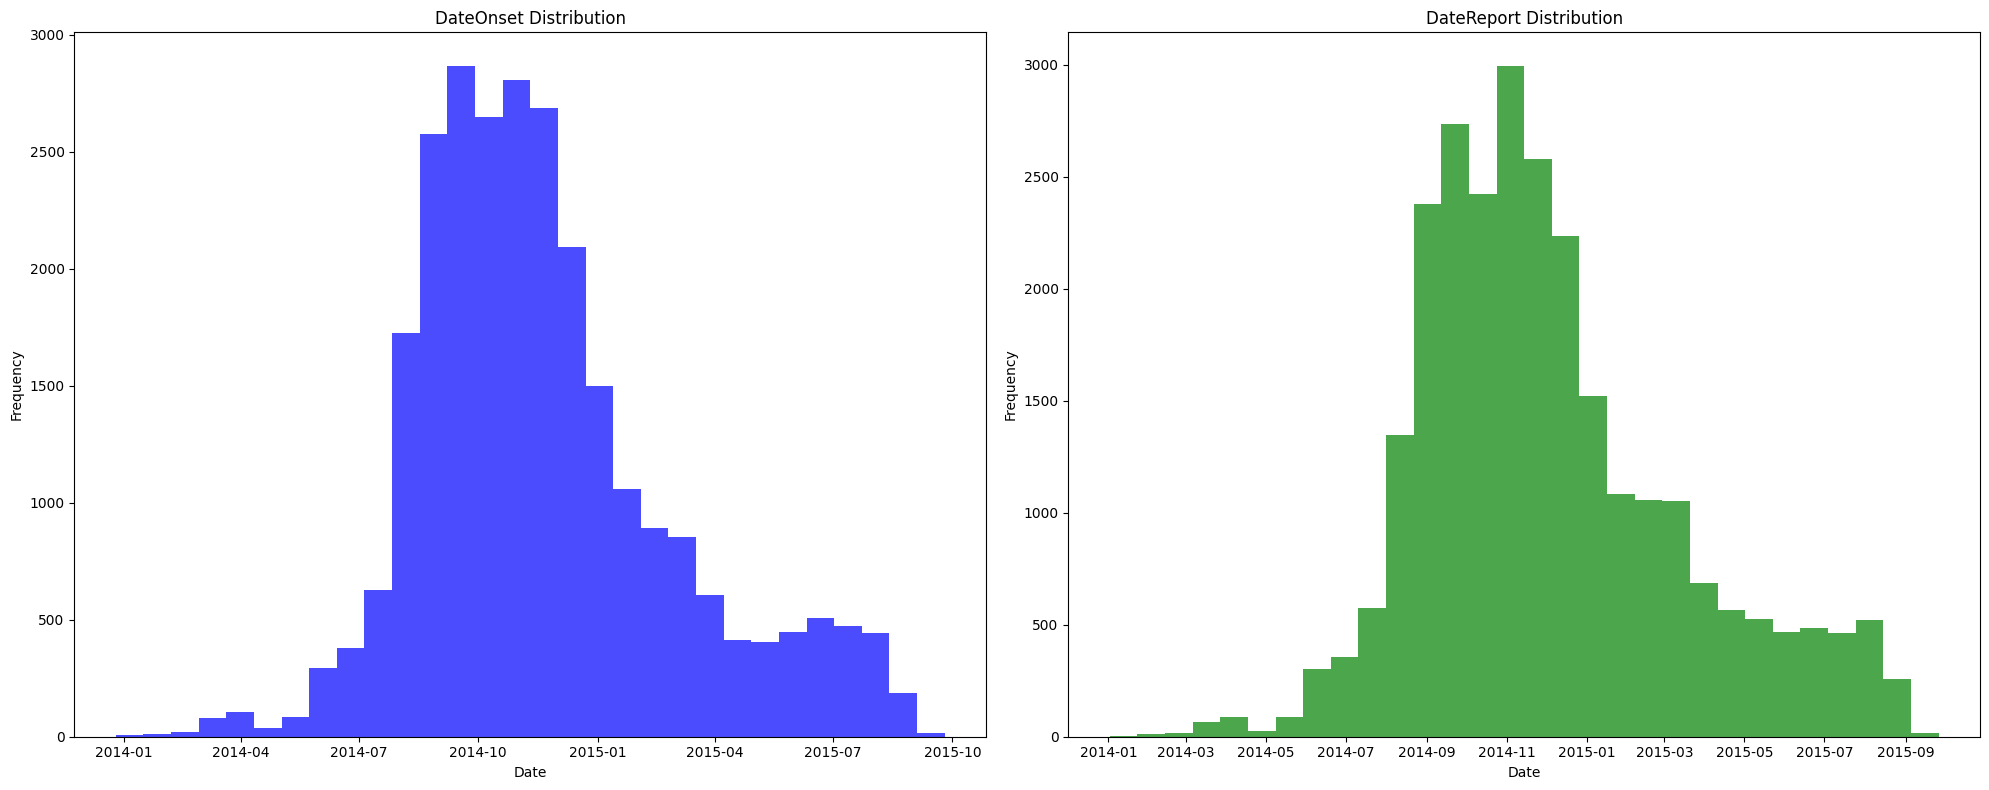

In [87]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.hist(ebola_v1['DateOnset'].dropna(), bins=30, color='blue', alpha=0.7)
plt.title('DateOnset Distribution')
plt.xlabel('Date')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(ebola_v1['DateReport'].dropna(), bins=30, color='green', alpha=0.7)
plt.title('DateReport Distribution')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('./images/date_distribution.png', bbox_inches='tight')
plt.show()

### 2. Plot Daily cases

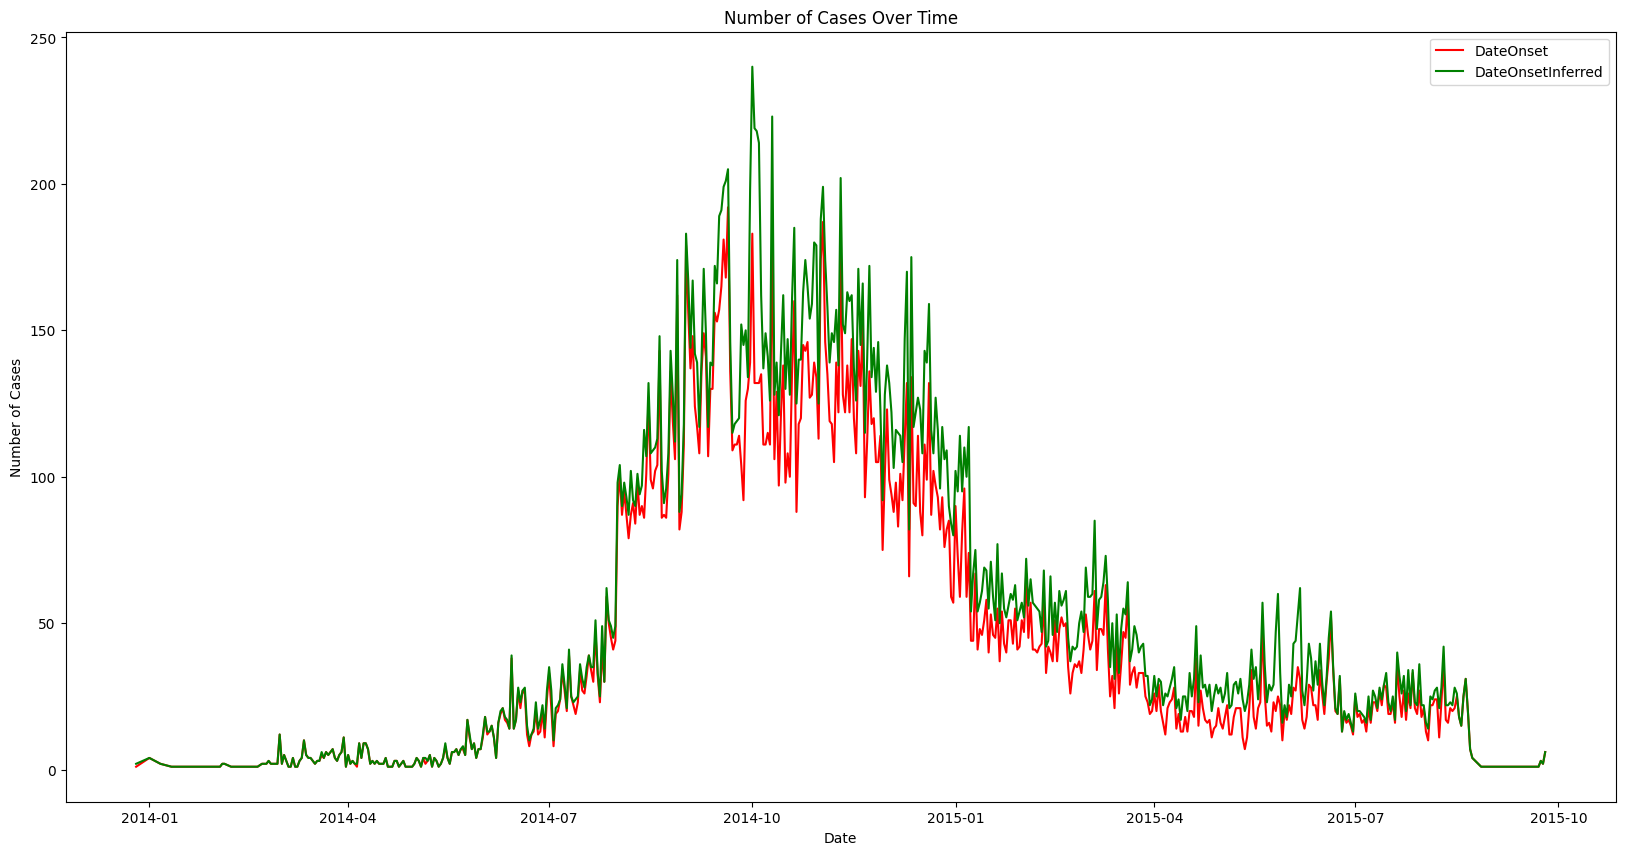

In [88]:
## plot the number of cases over time
plt.figure(figsize=(20, 10))
plt.plot(ebola_v1['DateOnset'].value_counts().sort_index(), linestyle='-', color='red')
plt.plot(ebola_v1['DateOnsetInferred'].value_counts().sort_index(), linestyle='-', color='green')
plt.title('Number of Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend(['DateOnset', 'DateOnsetInferred'])
# plt.xticks(rotation=45)
# plt.grid()
## save plot
plt.savefig('./images/cases_over_time.png', bbox_inches='tight')
plt.show()

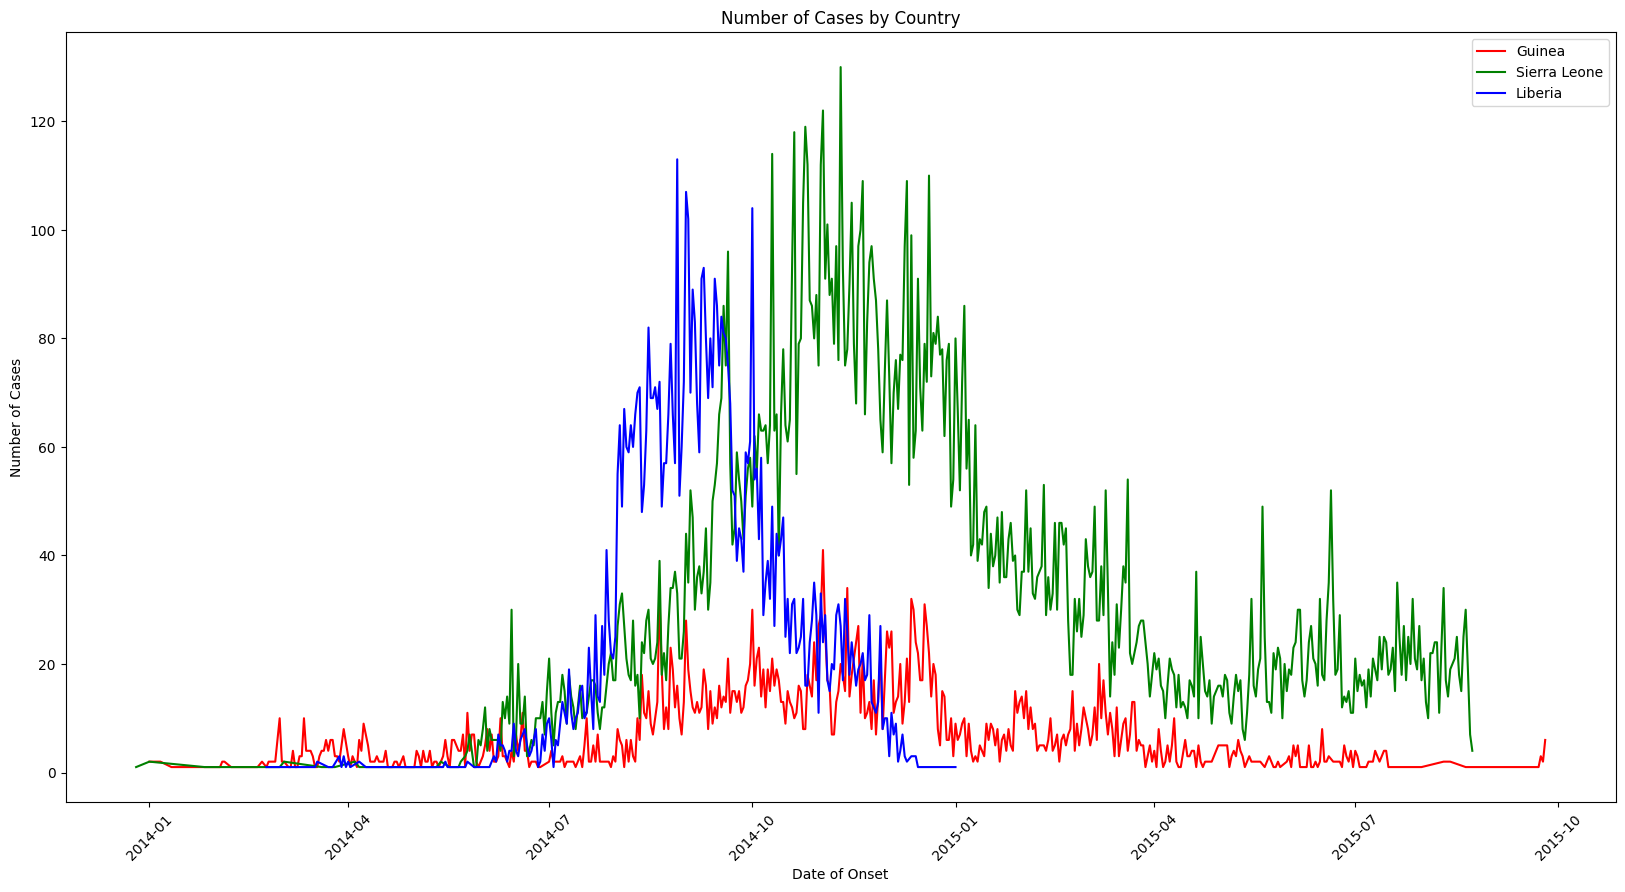

In [89]:
guinea = ebola_v1[ebola_v1['Country'] == 'Guinea']
sierra_leone = ebola_v1[ebola_v1['Country'] == 'Sierra Leone']
liberia = ebola_v1[ebola_v1['Country'] == 'Liberia']

# Plot the number of cases for each country
plt.figure(figsize=(20, 10))
plt.plot(guinea['DateOnset'].value_counts().sort_index(), linestyle='-', color='red')
plt.plot(sierra_leone['DateOnset'].value_counts().sort_index(), linestyle='-', color='green')
plt.plot(liberia['DateOnset'].value_counts().sort_index(),linestyle='-', color='blue')
plt.title('Number of Cases by Country')
plt.xlabel('Date of Onset')
plt.ylabel('Number of Cases')
plt.legend(['Guinea', 'Sierra Leone', 'Liberia'])
plt.xticks(rotation=45)
# plt.grid()
plt.savefig('./images/cases_by_country.png', bbox_inches='tight')
plt.show()

### 4. Let's plot the Cases accross the countries

In [90]:
# Count cases by country
cases_by_country = ebola_v1["CL_DistrictRes"].value_counts().reset_index()
cases_by_country.columns = ['Districts', 'cases']

# Merge with world data
world_with_cases = districts_filter.merge(cases_by_country, how='left', left_on='NAME_2', right_on='Districts')

In [91]:
world_with_cases['cases']=world_with_cases['cases'].fillna(0)
districts_filter['COUNTRY'].unique()

array(['Liberia', 'Guinea', 'Sierra Leone'], dtype=object)

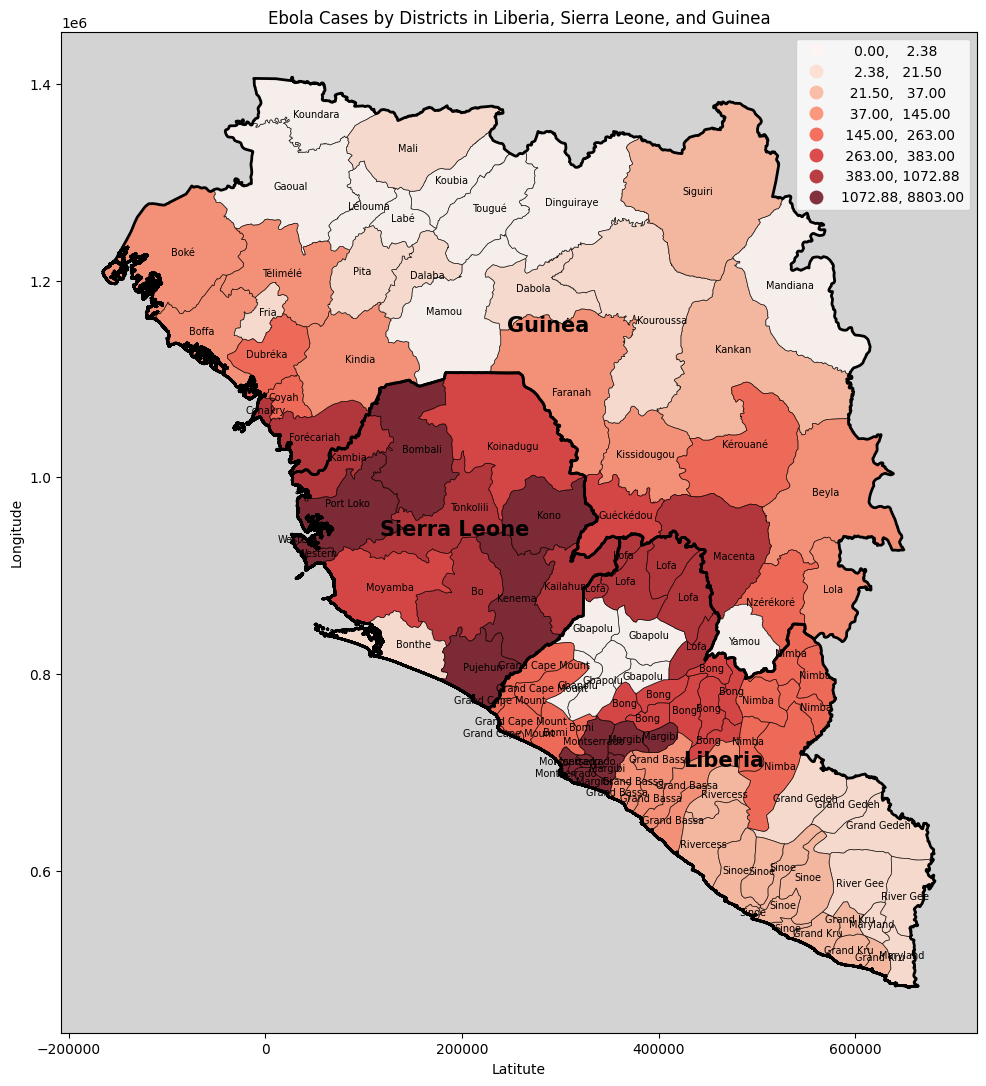

In [92]:
# Reproject to UTM Zone 29N (suitable for Liberia, Sierra Leone, Guinea)
world_with_cases = world_with_cases.to_crs(epsg=32629)

# Load country boundaries and filter for Liberia, Sierra Leone, and Guinea
countries = country_filter[country_filter['COUNTRY'].isin(['Liberia', 'Sierra Leone', 'Guinea'])]
countries = countries.to_crs(epsg=32629)  # Reproject to match world_with_cases

# Plot
fig, ax = plt.subplots(figsize=(30, 13))
ax.set_facecolor('lightgray')  # Add a light background

# Plot the choropleth map (regions)
world_with_cases.plot(
    column='cases', ax=ax, legend=True,
    missing_kwds={'color': 'lightgrey'},
    cmap='Reds', edgecolor='black',
    linewidth=0.5, alpha=0.8,
    scheme='quantiles', k=8
)

# Plot country boundaries with a thicker line
countries.boundary.plot(ax=ax, color='black', linewidth=2)

# Add country names at the centroids
for idx, row in countries.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['COUNTRY'], fontsize=15, fontweight='bold', color='black', ha='center', va='center')

# Add region names using representative_point() to reduce overlap
for point, label in zip(world_with_cases.geometry.representative_point(),
                        world_with_cases['NAME_2']):
    ax.text(point.x, point.y, label, fontsize=7, ha='center', va='center')

# Update the title and remove axes labels
plt.title('Ebola Cases by Districts in Liberia, Sierra Leone, and Guinea')
ax.set_xlabel('Latitute')
ax.set_ylabel('Longitude')

# Save the plot
plt.savefig('./images/cases_by_district_map2.png', bbox_inches='tight')

plt.show()

# 4. Prepare the Data for Modelling

## A. Get cases for each day

In [93]:
## Cases for each day
cases_by_day = ebola_v1.groupby('DateOnset')['CL_DistrictRes'].count().reset_index()
cases_by_day.columns = ['DateOnset', 'Cases']
cases_by_day['CumulativeCases'] = cases_by_day['Cases'].cumsum()

##death by day
death_by_day = ebola_v1[ebola_v1['FinalStatus']=='Dead']
death_by_day = death_by_day.groupby('DateOnset')['FinalStatus'].count().reset_index()
death_by_day['CummulativeDeaths'] = death_by_day['FinalStatus'].cumsum()

##death by day
survive_by_day = ebola_v1[ebola_v1['FinalStatus']=='Alive']
survive_by_day = survive_by_day.groupby('DateOnset')['FinalStatus'].count().reset_index()
survive_by_day['CummulativeSurvival'] = survive_by_day['FinalStatus'].cumsum()

In [94]:
h = ebola_v1[ebola_v1['DateOnset']=='2013-12-26']
# print(f"First date in the dataset: {h}")
h

,Country,EpiCaseDef,FinalStatus,DateOnset,DateOnsetInferred,DateReport,DateOutcomeComp,DateHospitalCurrentAdmit,Age,CL_DistrictRes,HospitalizedEver,TreatmentCendreType,TreatmentCentre,delay.onset.hospitalisation,QuarterOnsetInferred,retrospective
7125,Sierra Leone,suspected,NaN,2013-12-26,2013-12-26,NaT,NaT,NaT,53.0,Western,No,Not Hospitalised,NaN,NaN,Dec 2013,False


### Plot Cummulative Cases

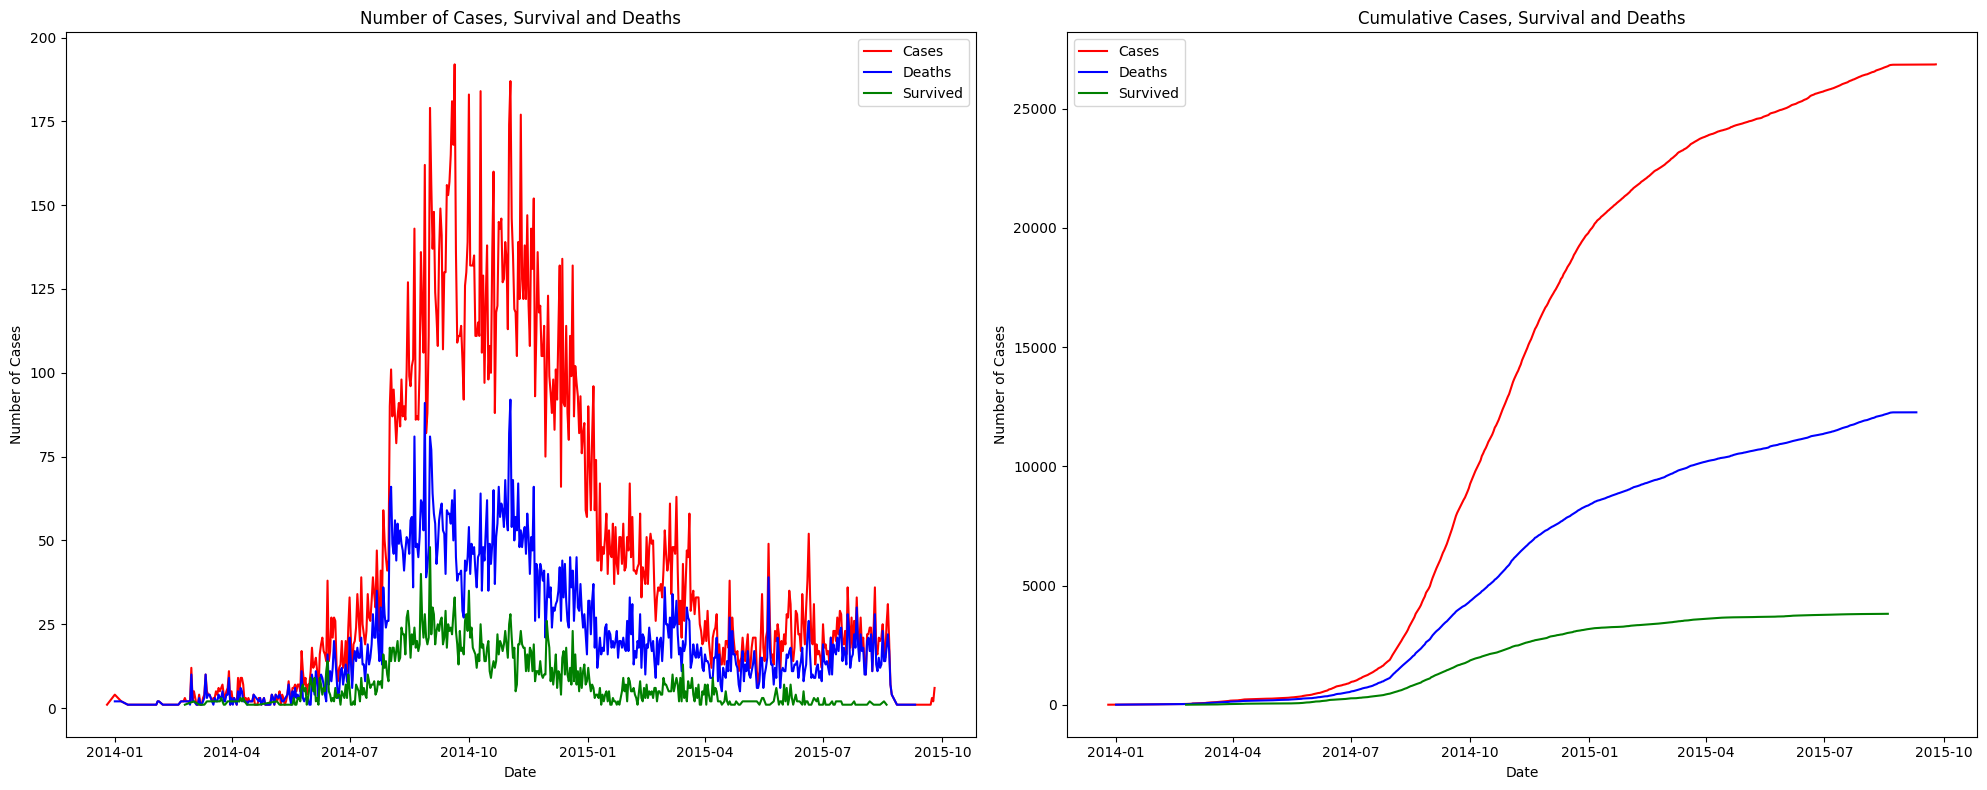

In [95]:
## Plot the number of cases and deaths over time and cumulative cases and deaths
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(cases_by_day['DateOnset'], cases_by_day['Cases'], linestyle='-', color='red')
plt.plot(death_by_day['DateOnset'], death_by_day['FinalStatus'], linestyle='-', color='blue')
plt.plot(survive_by_day['DateOnset'], survive_by_day['FinalStatus'], linestyle='-', color='green')
plt.title('Number of Cases, Survival and Deaths')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend(['Cases', 'Deaths', 'Survived'])

plt.subplot(1, 2, 2)
plt.plot(cases_by_day['DateOnset'], cases_by_day['CumulativeCases'], linestyle='-', color='red')
plt.plot(death_by_day['DateOnset'], death_by_day['CummulativeDeaths'], linestyle='-', color='blue')
plt.plot(survive_by_day['DateOnset'], survive_by_day['CummulativeSurvival'], linestyle='-', color='green')
plt.title('Cumulative Cases, Survival and Deaths')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend(['Cases', 'Deaths', 'Survived'])
plt.tight_layout()
plt.savefig('./images/cases_death_survival.png', bbox_inches='tight')
plt.show()


In [96]:
cases_by_day.describe()

,DateOnset,Cases,CumulativeCases
count,570,570.000000,570.000000
mean,2014-11-18 12:32:50.526315776,47.124561,13407.384211
min,2013-12-26 00:00:00,1.000000,1.000000
25%,2014-06-30 06:00:00,12.250000,922.250000
50%,2014-11-19 12:00:00,26.000000,15684.000000
75%,2015-04-10 18:00:00,84.750000,24052.500000
max,2015-09-25 00:00:00,192.000000,26861.000000
std,NaN,47.049691,10575.822100
